In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
import yaml
import json
from sklearn.experimental import enable_halving_search_cv
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import time


cwd = os.getcwd()
if cwd == "/app/scripts":
    train_path = "../data/extraction/train.json"
    test_path = "../data/extraction/test.json"
else:
    params = yaml.safe_load(open('params.yaml'))['hp']
    train_path = params['train']
    test_path = params['test']
    
train = pd.read_json(train_path)
test = pd.read_json(test_path)
train.head().T


,0,1,2,3,4
overall,positive,positive,negative,negative,positive
verified,True,False,True,True,False
reviewText,love hot great short,much harder excellent several first nice smoot...,other past,okay short long more half,middle aged cheap high best last easy decently...
summary,hot best,natural very easy,,poor long,outstanding incredible best
vote,1,3,1,1,183
weekday,4,5,3,3,0
VerifiedAndVoted,False,False,False,False,False
word_count,35,181,16,46,246
ReviewLength,163,934,76,222,1446


In [2]:
# split X, y
X_test = test.drop('overall', axis=1)
y_test = test['overall']
X_train = train.drop('overall', axis=1)
y_train = train['overall']


## Comparison of parameter optimization methods

**Random Search**.
- searches for a random combination of hyperparameters and tests them
- by the fact that it doesn't check on a one-to-one basis works much faster than GridSearch
- finds use when we have no idea of parameters that may work well in the model and/or when one has a significant number of them

**Grid Search**.
- checks every possible combination of hyperparameters to find the best combination
- works much slower than RandomSearch
- recommended for small parameter space

**Halving Grid Search**.
- an extension of GridSearch that divides the hyperparameter space into smaller subspaces, then performs a grid search on each subspace
- allows to reduce the computational cost of Grid Search
- May not be as efficient as RandomSearch for multidimensional parameter spaces

**Halving Random Search**.
- An extension of RandomSearch that randomly samples a subset in the hyperparameter space
- "Lighter" computationally than standard RandomSearch
- may not be efficient for non-dimensional parameter space


In [3]:
# prepare pipeline
vectorizer = CountVectorizer()
cat_preprocess = Pipeline([('ohe', OneHotEncoder())])
review_preprocess = Pipeline([('bow_review', vectorizer)])
summary_preprocess = Pipeline([('bow_summary', vectorizer)])
scaler = Pipeline([('scaler', MinMaxScaler())])

preprocess = ColumnTransformer([
    ('cat_preprocess', cat_preprocess, ['weekday', 'VerifiedAndVoted', 'verified']),
    ('review_preprocess', review_preprocess, 'reviewText'),
    ('summary_preprocess', summary_preprocess, 'summary'),
    ('scaler', scaler, ['word_count', 'ReviewLength', 'vote'])])

pipeline = Pipeline([
                ('preprocess', preprocess),
                ('clf', RandomForestClassifier())])

In [4]:
param_grid = [
        {
            "preprocess__summary_preprocess__bow_summary__max_features": [50, 100, 200, 500],
            "preprocess__review_preprocess__bow_review__max_features": [50, 100, 200, 500]
        }]

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1,
                                        scoring='f1_macro')
randomized = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=1, n_jobs=-1,
                                        scoring='f1_macro')
halvingrandom = HalvingRandomSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=1, n_jobs=-1,
                                        scoring='f1_macro')
halvinggrid = HalvingGridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1,
                                        scoring='f1_macro')
print("Grid search started")
start_time = time.time()
grid.fit(X_train, y_train)
score_grid = grid.best_estimator_.score(X_test,y_test)
print(grid.best_estimator_)
print(f'Grid search score:{score_grid}')
end_time = time.time()
t_grid = end_time-start_time
print(f"Grid ended. Time passed: {t_grid}")

print("Radomized search started")
start_time = time.time()
randomized.fit(X_train, y_train)
score_randomized = randomized.best_estimator_.score(X_test,y_test)
print(randomized.best_estimator_)
print(f'randomized search score:{score_randomized}')
end_time = time.time()
t_random = end_time-start_time
print(f"Randomized ended. Time passed: {t_random}")

print("Halving Random search startedd")
start_time = time.time()
halvingrandom.fit(X_train, y_train)
score_hr = halvingrandom.best_estimator_.score(X_test,y_test)
print(halvingrandom.best_estimator_)
print(f'Halving random search score:{score_hr}')
end_time = time.time()
t_hr = end_time-start_time
print(f"Halvinf Random ended. Time passed: {t_hr}")

print("Halving Grid search startedd")
start_time = time.time()
halvinggrid.fit(X_train, y_train)
score_hg = halvinggrid.best_estimator_.score(X_test,y_test)
print(halvinggrid.best_estimator_)
print(f'Halving grid search score:{score_hg}')
end_time = time.time()
r_hg = end_time-start_time
print(f"Halving Grid ended. Time passed: {end_time-start_time}")

Grid search started
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_preprocess',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['weekday',
                                                   'VerifiedAndVoted',
                                                   'verified']),
                                                 ('review_preprocess',
                                                  Pipeline(steps=[('bow_review',
                                                                   CountVectorizer(max_features=500))]),
                                                  'reviewText'),
                                                 ('summary_preprocess',
                                                  Pipeline(steps=[(

/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 16 is smaller than n_iter=799. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 6
n_resources: 90
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 270
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_preprocess',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['weekday',
                                                   'VerifiedAndVoted',
                                                   'verified']),
                                                 ('review_preprocess',
                                                  Pipeline(steps=[('bow_review',
                                                                   CountVectorizer(max_features=500))]),
                                                  'reviewText'

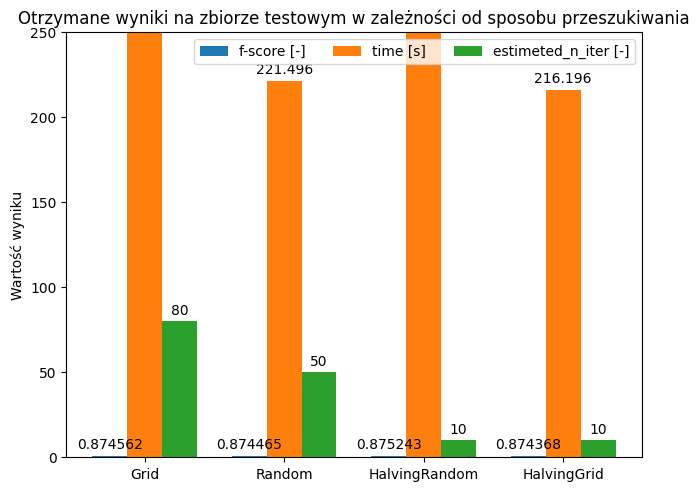

In [5]:

import matplotlib.pyplot as plt

algos = ['Grid', 'Random', 'HalvingRandom', 'HalvingGrid']
scores = {'f-score [-]': (score_grid, score_randomized, score_hr, score_hg ),
       'time [s]': (t_grid, t_random,t_hr,r_hg), 
       'estimeted_n_iter [-]':(80, 50, 10, 10),
       }
x = np.arange(len(algos))  
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('The results obtained on the test set depending on the search method')
ax.set_xticks(x + width, algos)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 250)


plt.show()

As seen above, GridSearch proved to be the most time-consuming (as assumed in the method descriptions). Nevertheless, comparable results with nearly 15 times less time were obtained by **HalvingRandom**. It gave slightly lower results than the standard Grid or random but yielded a high computational advantage, which, with there marginal equation of 0.01%, is not crucial in the context of the result itself. However, it is worth noting that this way of searching is based on randomness and may not truly select the best parameters, and is not recommended for a small parameter space. The best combination of parameters was selected based on the ratio of the obtained result to the amount of execution time, as shown below

In [6]:

methods_best_params = {grid: score_grid/t_grid, randomized: score_randomized/t_random, halvingrandom: score_hr/t_hr, 
                      halvinggrid: score_hg/ r_hg}
max_key, max_value = max(methods_best_params.items(), key=lambda x: x[1])
print(f"The key with the highest value is {max_key} with a value of {max_value}.")

max_review = max_key.best_params_['preprocess__review_preprocess__bow_review__max_features']
max_summary = max_key.best_params_['preprocess__summary_preprocess__bow_summary__max_features']
print(max_key.best_params_['preprocess__review_preprocess__bow_review__max_features'])
print(max_key.best_params_['preprocess__summary_preprocess__bow_summary__max_features'])

The key with the highest value is HalvingGridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                               ColumnTransformer(transformers=[('cat_preprocess',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['weekday',
                                                                                 'VerifiedAndVoted',
                                                                                 'verified']),
                                                                               ('review_preprocess',
                                                                                Pipeline(steps=[('bow_review',
                                                                                      

In [7]:
# TF-id vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

review_preprocess = Pipeline([('bow_review', TfidfVectorizer(max_features=max_review))])
summary_preprocess = Pipeline([('bow_summary', TfidfVectorizer(max_features=max_summary))])

pipelinetf = Pipeline([
                ('preprocess', preprocess),
                ('clf', RandomForestClassifier())])

print("Tf-id started")
start_time = time.time()
pipelinetf.fit(X_train, y_train)
y_pred = pipelinetf.predict(X_test)
score_tf = f1_score(y_test, y_pred, average='macro')
print(f"Score for Tf-id: {score_tf}")
end_time = time.time()
print(f"Tf-id ended. Time passed: {end_time-start_time}")


Tf-id started
Score for Tf-id: 0.6594468023039587
Tf-id ended. Time passed: 92.69872879981995


In [8]:
#Word2vec
from sklearn.base import BaseEstimator, TransformerMixin

class TransformerWord2Vec(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=100, window=5, min_count=1, w=4):
        self.max_features = max_features
        self.window = window
        self.min_count = min_count
        self.w = w
        self.word2vec = None
        
    def fit(self, X, y=None):
        texts_list = [text.split() for text in X]
        self.word2vec = Word2Vec(texts_list, vector_size=self.max_features, window=self.window,
                                 min_count=self.min_count, w=self.w)
        return self
    
    def transform(self, X, y=None):
        word_vectors = []
        for text in X:
            text_vector = []
            for word in text.split():
                if word in self.word2vec.wv.key_to_index:
                    text_vector.append(self.word2vec.wv[word])
            if text_vector:
                text_vector = np.mean(text_vector, axis=0)
                word_vectors.append(text_vector)
            else:
                word_vectors.append(np.zeros(self.max_features))
        return np.array(word_vectors)



review_preprocess = Pipeline([('bow_review', TransformerWord2Vec(max_features=max_review))])
summary_preprocess = Pipeline([('bow_summary', TransformerWord2Vec(max_features=max_summary))])

pipelinew2v = Pipeline([
                ('preprocess', preprocess),
                ('clf', RandomForestClassifier())])

print("Word2Vec started")
start_time = time.time()
pipelinew2v.fit(X_train, y_train)
y_predw2v = pipelinew2v.predict(X_test)
score_w2v = f1_score(y_test, y_predw2v, average='macro')
print(f"Score for Word2Vec: {score_w2v}")
end_time = time.time()
print(f"Word2Vec ended. Time passed: {end_time-start_time}")


                
    

Word2Vec started
Score for Word2Vec: 0.6533832224811457
Word2Vec ended. Time passed: 14.268145084381104


In [9]:
review_preprocess = Pipeline([('bow_review', CountVectorizer(max_features=max_review))])
summary_preprocess = Pipeline([('bow_summary', CountVectorizer(max_features=max_summary))])

pipelinecv = Pipeline([
                ('preprocess', preprocess),
                ('clf', RandomForestClassifier())])

print("CountVectorizer started")
start_time = time.time()
pipelinecv.fit(X_train, y_train)
y_predcv = pipelinecv.predict(X_test)
score_cv = f1_score(y_test, y_predcv, average='macro')
print(f"Score for CountVectorizer: {score_cv}")
end_time = time.time()
print(f"CountVectorizer ended. Time passed: {end_time-start_time}")

CountVectorizer started
Score for CountVectorizer: 0.654273885040402
CountVectorizer ended. Time passed: 314.1592891216278


Below is a comparison of the results for each text vectorization method.

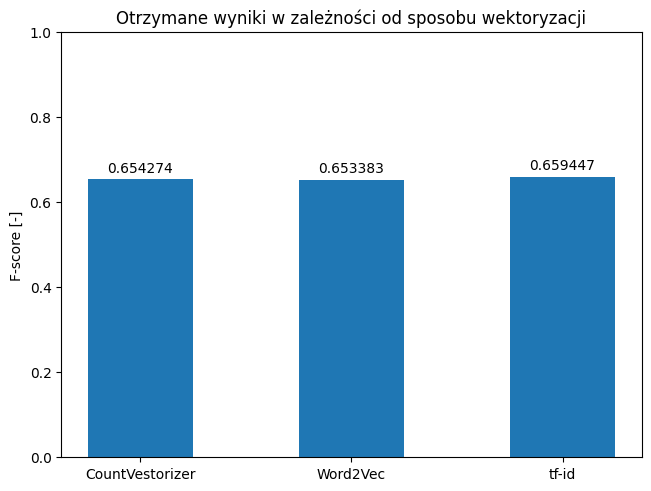

In [10]:
v_types = ['CountVestorizer', 'Word2Vec', 'tf-id']
scores = {'f-score [-]': ( score_cv, score_w2v, score_tf ),
       }
x = np.arange(len(v_types))  
width = 0.5 # the width of the bars
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    rects = ax.bar(x, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F-score [-]')
ax.set_title('Otrzymane wyniki w zależności od sposobu wektoryzacji')
ax.set_xticks(x, v_types)
ax.set_ylim(0, 1)

plt.show()

In summary, the best combination was on par with **Word2Vec** and **CountVectorizer**, but no significant improvement or difference in performance was observed. This may have been due to the fact that the text had previously been cleaned with the Spacy library - only words registered as likely to carry value toward recognizing senstiment were left, so Word2Vec based on the context of the utterance may not have extracted enough information from the context. CountVectorizer simply counts the occurrences, without analyzing the context, hence the comparable result with Word2Vec may have been due to its inability to extract the context.